In [1]:
from ultralytics import YOLO
from ultralytics.yolo.utils.plotting import colors
from ultralytics.yolo.utils import ops

from openvino.runtime import Core, Model
from openvino.runtime import serialize
from openvino.preprocess import PrePostProcessor
from openvino.runtime import Type, Layout

import nncf

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import pandas as pd

import collections
import time
from typing import Tuple, Dict
from pathlib import Path

import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

from IPython import display
from notebook_utils import VideoPlayer
import urllib.request


INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, onnx, openvino


# **DEALING WITH CUSTOM DATA**

### *TRAINING MODEL*

In [2]:
dataset = './DATASET/POTHOLE/data.yaml'

In [5]:
model_pothole = YOLO('yolov8n.yaml').load('yolov8n.pt')


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               


  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  8                  -1  1    460288  ultralytics.nn.modules.block.C2f             [256, 256, 1, True]           
  9                  -1  1    164608  ultralytics.nn.modules.block.SPPF            [256, 256, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  1    148224  ultralytics.nn.modules.block.C2f             [384, 128, 1]                 
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

In [6]:
model_pothole.train(data=dataset,
                    epochs = 500,
                    patience=350,
                    imgsz=480,
                    batch=16,
                    cache=True,
                    device=0,
                    workers=0,
                    project='POTHOLE',
                    name='TRAINING001',
                    exist_ok=True,
                    optimizer='auto')

Ultralytics YOLOv8.0.123  Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
yolo\engine\trainer: task=detect, mode=train, model=yolov8n.yaml, data=./DATASET/POTHOLE/data.yaml, epochs=500, patience=350, batch=16, imgsz=480, save=True, save_period=-1, cache=True, device=0, workers=0, project=POTHOLE, name=TRAINING001, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, o

### *VALIDATING MODEL*

In [4]:
model_trained = YOLO('POTHOLE/TRAINING001/weights/best.pt')

In [5]:
dataset = './DATASET/POTHOLE/data.yaml'

In [5]:
metrics = model_trained.val(dataset)

Ultralytics YOLOv8.0.123  Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)


val: Scanning C:\Users\zakis\Desktop\PROJECT101\Lubang - Chip\DATASET\POTHOLE\valid\labels.cache... 135 images, 1 backgrounds, 0 corrupt: 100%|██████████| 135/135 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.90it/s]
                   all        135        453      0.857       0.79      0.823      0.343
Speed: 1.1ms preprocess, 5.0ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\val2


In [6]:
metrics.box.map

0.34297757503613

In [7]:
metrics.box.map50

0.8227499071871176

In [9]:
metrics.box.map75

0.19809996602248953

In [10]:
metrics.box.maps

array([    0.34298])

### *TRY INFERENCING*

In [6]:
img1 = 'extracted 5 fps/28.jpg'
img1 = cv2.imread(img1)

res1 = model_trained.predict(img1)


0: 288x480 5 potholes, 108.5ms
Speed: 2.0ms preprocess, 108.5ms inference, 5.0ms postprocess per image at shape (1, 3, 288, 480)


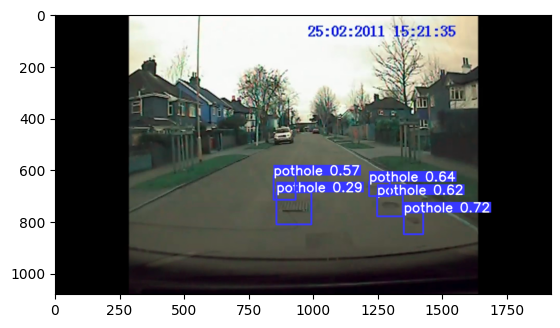

In [12]:
ploted_res = res1[0].plot()
plt.imshow(ploted_res)

### *EXPORTING MODEL TO OPENVINO*

In [2]:
model_trained = YOLO('POTHOLE/TRAINING001/weights/best.pt')

model_trained.export(format='openvino', dynamic=True, half=False)

Ultralytics YOLOv8.0.123  Python-3.10.11 torch-2.0.1+cu118 CPU
YOLOv8n summary (fused): 168 layers, 3005843 parameters, 0 gradients

PyTorch: starting from POTHOLE\TRAINING001\weights\best.pt with input shape (1, 3, 480, 480) BCHW and output shape(s) (1, 5, 4725) (5.9 MB)
requirements: Ultralytics requirement "onnx>=1.12.0" not found, attempting AutoUpdate...
     ---------------------------------------- 13.3/13.3 MB 2.2 MB/s eta 0:00:00
     -------------------------------------- 422.5/422.5 kB 2.6 MB/s eta 0:00:00

requirements: 1 package updated per ['onnx>=1.12.0']
requirements:  Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.14.0 opset 17...
ONNX: export success  35.4s, saved as POTHOLE\TRAINING001\weights\best.onnx (11.5 MB)


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================




OpenVINO: starting export with openvino 2023.0.0-10926-b4452d56304-releases/2023/0...
OpenVINO: export success  4.1s, saved as POTHOLE\TRAINING001\weights\best_openvino_model\ (11.8 MB)

Export complete (40.2s)
Results saved to C:\Users\zakis\Desktop\PROJECT101\Lubang - Chip\POTHOLE\TRAINING001\weights
Predict:         yolo predict task=detect model=POTHOLE\TRAINING001\weights\best_openvino_model imgsz=480 
Validate:        yolo val task=detect model=POTHOLE\TRAINING001\weights\best_openvino_model imgsz=480 data=./DATASET/POTHOLE/data.yaml 
Visualize:       https://netron.app


'POTHOLE\\TRAINING001\\weights\\best_openvino_model'

# **TESTING MODEL**

### *GETTING LABEL MAP*

In [3]:
model_trained = YOLO('POTHOLE/TRAINING001/weights/best.pt')
label_map = model_trained.model.names  

### *HELPER FUNCTION*

In [4]:
def plot_one_box(box:np.ndarray, img:np.ndarray, color:Tuple[int, int, int] = None, mask:np.ndarray = None, label:str = None, line_thickness:int = 5):
    """
    Helper function for drawing single bounding box on image
    Parameters:
        x (np.ndarray): bounding box coordinates in format [x1, y1, x2, y2]
        img (no.ndarray): input image
        color (Tuple[int, int, int], *optional*, None): color in BGR format for drawing box, if not specified will be selected randomly
        mask (np.ndarray, *optional*, None): instance segmentation mask polygon in format [N, 2], where N - number of points in contour, if not provided, only box will be drawn
        label (str, *optonal*, None): box label string, if not provided will not be provided as drowing result
        line_thickness (int, *optional*, 5): thickness for box drawing lines
    """
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
    if mask is not None:
        image_with_mask = img.copy()
        mask
        cv2.fillPoly(image_with_mask, pts=[mask.astype(int)], color=color)
        img = cv2.addWeighted(img, 0.5, image_with_mask, 0.5, 1)
    return img


def draw_results(results:Dict, source_image:np.ndarray, label_map:Dict):
    """
    Helper function for drawing bounding boxes on image
    Parameters:
        image_res (np.ndarray): detection predictions in format [x1, y1, x2, y2, score, label_id]
        source_image (np.ndarray): input image for drawing
        label_map; (Dict[int, str]): label_id to class name mapping
    Returns:

    """
    boxes = results["det"]
    masks = results.get("segment")
    h, w = source_image.shape[:2]
    for idx, (*xyxy, conf, lbl) in enumerate(boxes):
        label = f'{label_map[int(lbl)]} {conf:.2f}'
        mask = masks[idx] if masks is not None else None
        source_image = plot_one_box(xyxy, source_image, mask=mask, label=label, color=colors(int(lbl)), line_thickness=1)
    return source_image

In [5]:
def letterbox(img: np.ndarray, new_shape:Tuple[int, int] = (480, 480), color:Tuple[int, int, int] = (114, 114, 114), auto:bool = False, scale_fill:bool = False, scaleup:bool = False, stride:int = 32):
    """
    Resize image and padding for detection. Takes image as input,
    resizes image to fit into new shape with saving original aspect ratio and pads it to meet stride-multiple constraints

    Parameters:
      img (np.ndarray): image for preprocessing
      new_shape (Tuple(int, int)): image size after preprocessing in format [height, width]
      color (Tuple(int, int, int)): color for filling padded area
      auto (bool): use dynamic input size, only padding for stride constrins applied
      scale_fill (bool): scale image to fill new_shape
      scaleup (bool): allow scale image if it is lower then desired input size, can affect model accuracy
      stride (int): input padding stride
    Returns:
      img (np.ndarray): image after preprocessing
      ratio (Tuple(float, float)): hight and width scaling ratio
      padding_size (Tuple(int, int)): height and width padding size


    """
    # Resize and pad image while meeting stride-multiple constraints
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scale_fill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)


def preprocess_image(img0: np.ndarray):
    """
    Preprocess image according to YOLOv8 input requirements.
    Takes image in np.array format, resizes it to specific size using letterbox resize and changes data layout from HWC to CHW.

    Parameters:
      img0 (np.ndarray): image for preprocessing
    Returns:
      img (np.ndarray): image after preprocessing
    """
    # resize
    img = letterbox(img0)[0]

    # Convert HWC to CHW
    img = img.transpose(2, 0, 1)
    img = np.ascontiguousarray(img)
    return img


def image_to_tensor(image:np.ndarray):
    """
    Preprocess image according to YOLOv8 input requirements.
    Takes image in np.array format, resizes it to specific size using letterbox resize and changes data layout from HWC to CHW.

    Parameters:
      img (np.ndarray): image for preprocessing
    Returns:
      input_tensor (np.ndarray): input tensor in NCHW format with float32 values in [0, 1] range
    """
    input_tensor = image.astype(np.float32)  # uint8 to fp32
    input_tensor /= 255.0  # 0 - 255 to 0.0 - 1.0

    # add batch dimension
    if input_tensor.ndim == 3:
        input_tensor = np.expand_dims(input_tensor, 0)
    return input_tensor

In [6]:
def postprocess(
    pred_boxes:np.ndarray,
    input_hw:Tuple[int, int],
    orig_img:np.ndarray,
    min_conf_threshold:float = 0.25,
    nms_iou_threshold:float = 0.7,
    agnosting_nms:bool = False,
    max_detections:int = 300,
    pred_masks:np.ndarray = None,
    retina_mask:bool = False
):
    """
    YOLOv8 model postprocessing function. Applied non maximum supression algorithm to detections and rescale boxes to original image size
    Parameters:
        pred_boxes (np.ndarray): model output prediction boxes
        input_hw (np.ndarray): preprocessed image
        orig_image (np.ndarray): image before preprocessing
        min_conf_threshold (float, *optional*, 0.25): minimal accepted confidence for object filtering
        nms_iou_threshold (float, *optional*, 0.45): minimal overlap score for removing objects duplicates in NMS
        agnostic_nms (bool, *optiona*, False): apply class agnostinc NMS approach or not
        max_detections (int, *optional*, 300):  maximum detections after NMS
        pred_masks (np.ndarray, *optional*, None): model ooutput prediction masks, if not provided only boxes will be postprocessed
        retina_mask (bool, *optional*, False): retina mask postprocessing instead of native decoding
    Returns:
       pred (List[Dict[str, np.ndarray]]): list of dictionary with det - detected boxes in format [x1, y1, x2, y2, score, label] and segment - segmentation polygons for each element in batch
    """
    nms_kwargs = {"agnostic": agnosting_nms, "max_det":max_detections}
    # if pred_masks is not None:
    #     nms_kwargs["nm"] = 32
    preds = ops.non_max_suppression(
        torch.from_numpy(pred_boxes),
        min_conf_threshold,
        nms_iou_threshold,
        nc=0,    # only 1 class
        **nms_kwargs
    )
    results = []
    proto = torch.from_numpy(pred_masks) if pred_masks is not None else None

    for i, pred in enumerate(preds):
        shape = orig_img[i].shape if isinstance(orig_img, list) else orig_img.shape
        if not len(pred):
            results.append({"det": [], "segment": []})
            continue
        if proto is None:
            pred[:, :4] = ops.scale_boxes(input_hw, pred[:, :4], shape).round()
            results.append({"det": pred})
            continue
        if retina_mask:
            pred[:, :4] = ops.scale_boxes(input_hw, pred[:, :4], shape).round()
            masks = ops.process_mask_native(proto[i], pred[:, 6:], pred[:, :4], shape[:2])  # HWC
            segments = [ops.scale_segments(input_hw, x, shape, normalize=False) for x in ops.masks2segments(masks)]
        else:
            masks = ops.process_mask(proto[i], pred[:, 6:], pred[:, :4], input_hw, upsample=True)
            pred[:, :4] = ops.scale_boxes(input_hw, pred[:, :4], shape).round()
            segments = [ops.scale_segments(input_hw, x, shape, normalize=False) for x in ops.masks2segments(masks)]
        results.append({"det": pred[:, :6].numpy(), "segment": segments})
    return results

### *INFERENCE TEST ON ORIGINAL MODEL*

In [7]:
def detect(image:np.ndarray, model):
    """
    OpenVINO YOLOv8 model inference function. Preprocess image, runs model inference and postprocess results using NMS.
    Parameters:
        image (np.ndarray): input image.
        model (Model): OpenVINO compiled model.
    Returns:
        detections (np.ndarray): detected boxes in format [x1, y1, x2, y2, score, label]
    """
    num_outputs = len(model.outputs)
    preprocessed_image = preprocess_image(image)
    input_tensor = image_to_tensor(preprocessed_image)
    result = model(input_tensor)
    boxes = result[model.output(0)]
    masks = None
    if num_outputs > 1:
        masks = result[model.output(1)]
    input_hw = input_tensor.shape[2:]
    detections = postprocess(pred_boxes=boxes, input_hw=input_hw, orig_img=image, pred_masks=masks)
    return detections

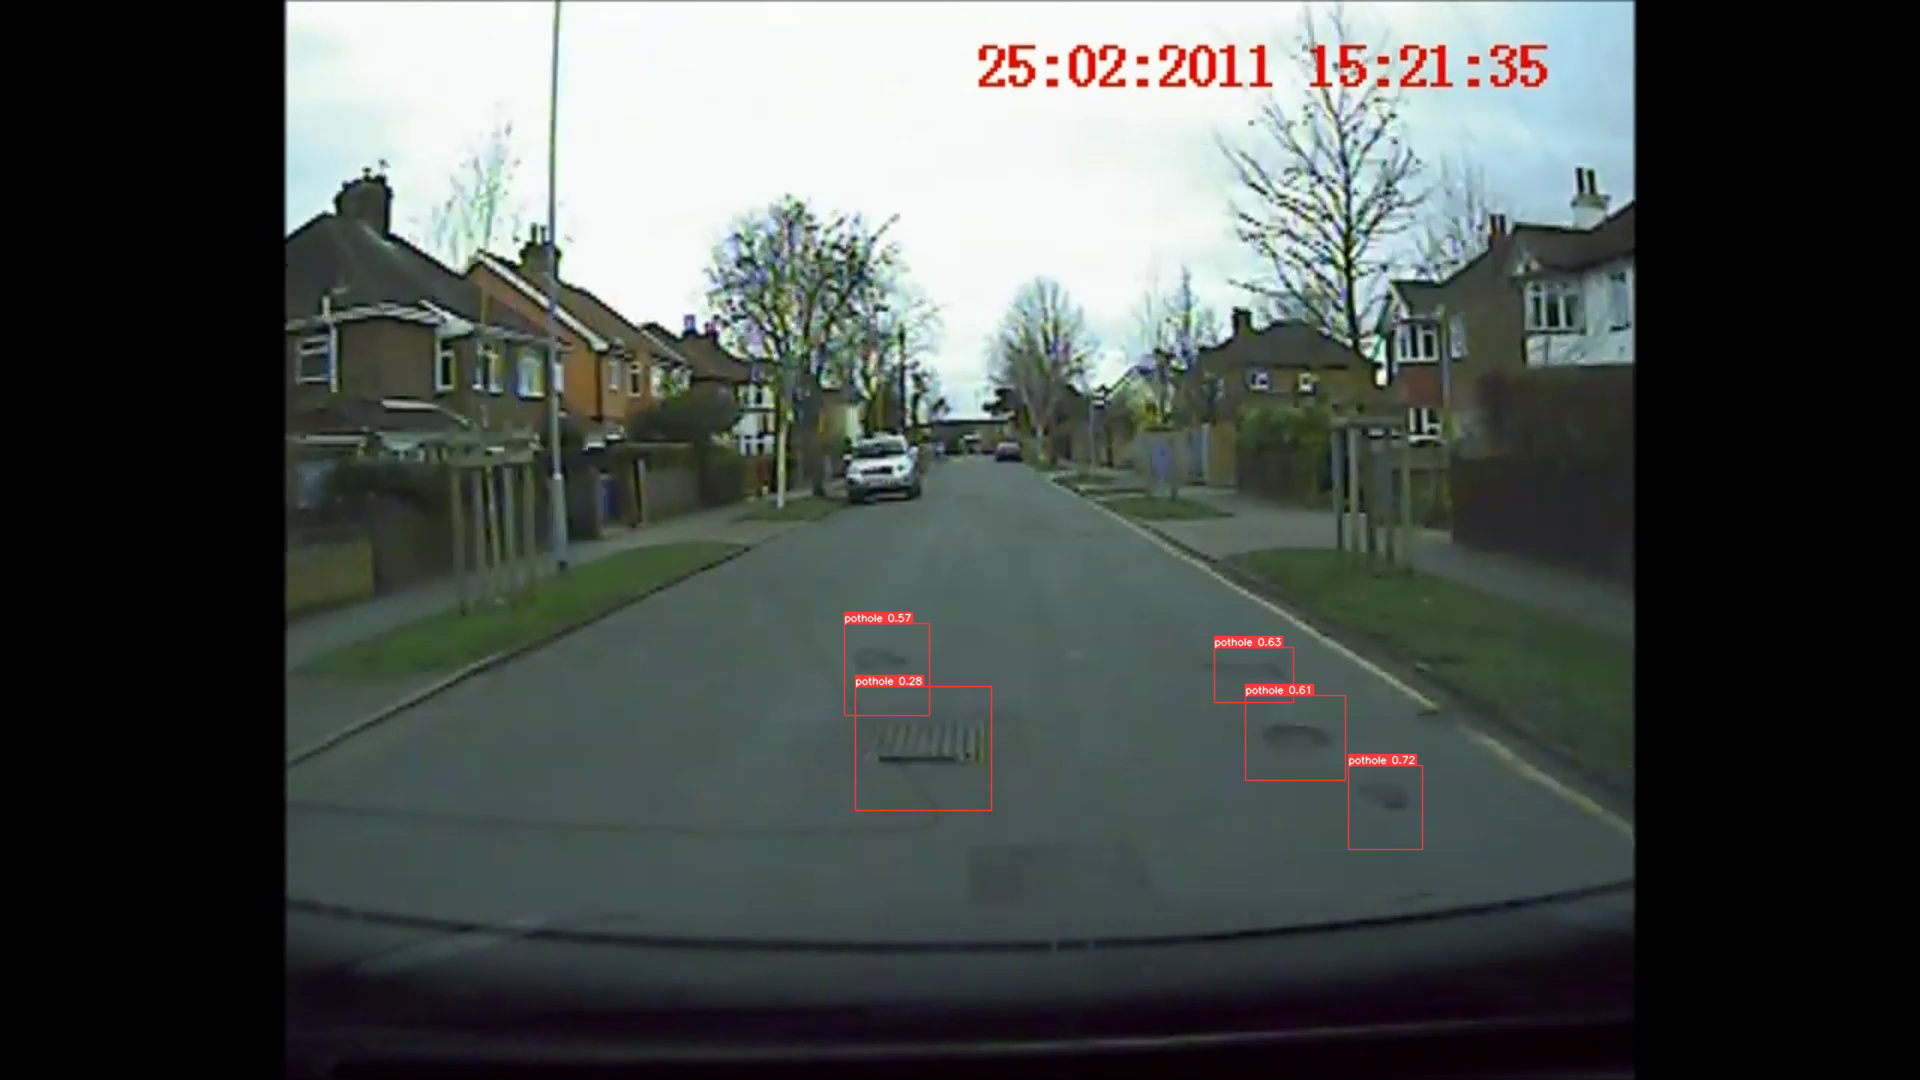

In [8]:
core = Core()
det_model_path = 'POTHOLE/TRAINING001/weights/best_openvino_model/best.xml'
IMAGE_PATH = 'extracted 5 fps/28.jpg'

det_ov_model = core.read_model(det_model_path)
device = "GPU.0"
if device != "CPU":
    det_ov_model.reshape({0: [1, 3, 480, 480]})
det_compiled_model = core.compile_model(det_ov_model, device)


input_image = np.array(Image.open(IMAGE_PATH))
detections = detect(input_image, det_compiled_model)[0]
image_with_boxes = draw_results(detections, input_image, label_map)

Image.fromarray(image_with_boxes)

# **VALIDATING MODEL**

In [20]:
!yolo val model='./POTHOLE/TRAINING001/weights/best_openvino_model/' data='./DATASET/POTHOLE/data.yaml'

WARNING  Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify', or 'pose'.
Ultralytics YOLOv8.0.125  Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Loading POTHOLE\TRAINING001\weights\best_openvino_model for OpenVINO inference...
Forcing batch=1 square inference (1,3,640,640) for non-PyTorch models

val: Scanning C:\Users\zakis\Desktop\PROJECT101\Chip\DATASET\POTHOLE\valid\labels...:   0%|          | 0/134 [00:00<?, ?it/s]
val: Scanning C:\Users\zakis\Desktop\PROJECT101\Chip\DATASET\POTHOLE\valid\labels... 134 images, 0 backgrounds, 0 corrupt: 100%|██████████| 134/134 [00:00<00:00, 1992.83it/s]
val: New cache created: C:\Users\zakis\Desktop\PROJECT101\Chip\DATASET\POTHOLE\valid\labels.cache

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/134 [00:00<?, ?it/s]
                 Class     Images  In

Text(0.5, 1.0, 'PR Curve')

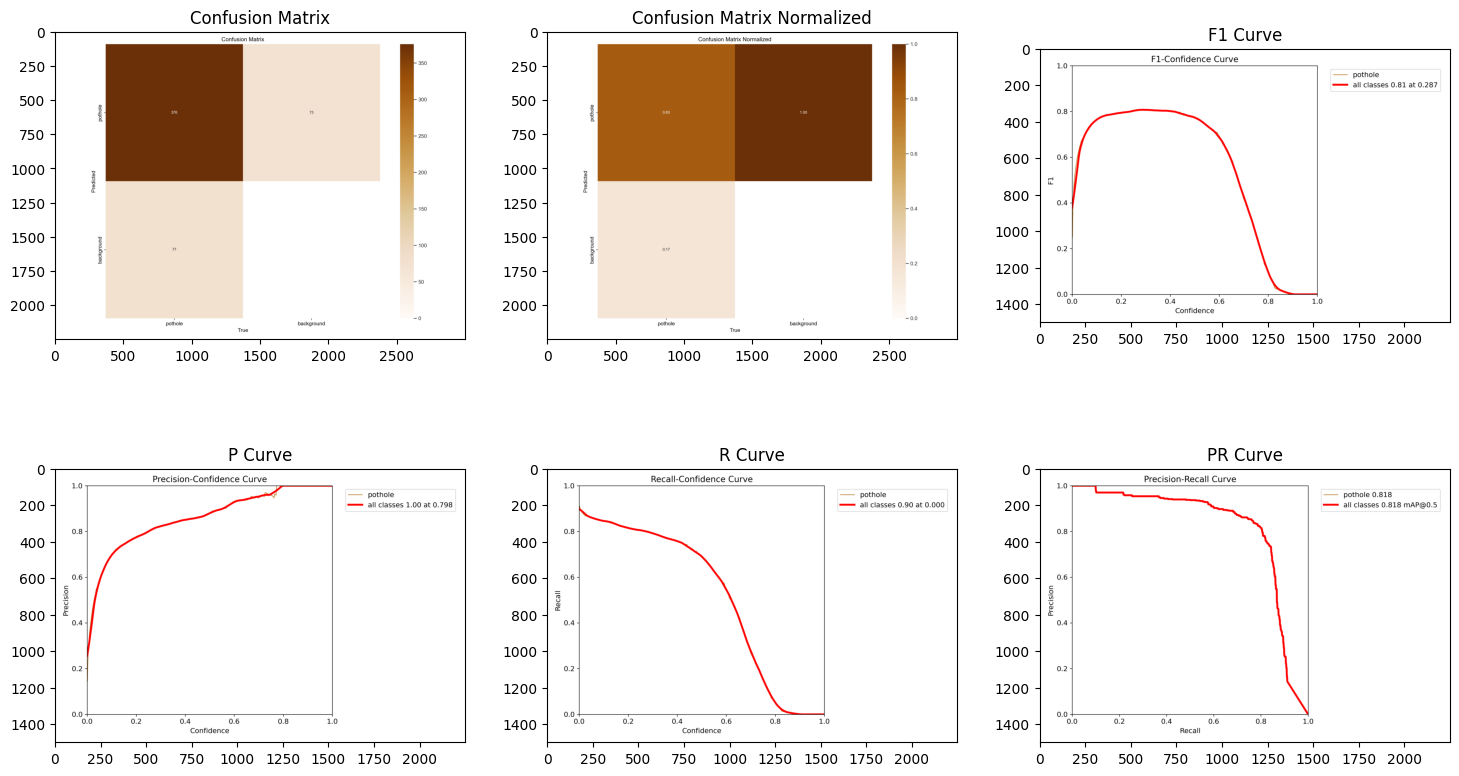

In [38]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 10))
fig

cf_matrix = cv2.imread('./runs/detect/val4/confusion_matrix.png')
ax1.imshow(cf_matrix)
ax1.set_title('Confusion Matrix')

cf_matrix_normalized = cv2.imread('./runs/detect/val4/confusion_matrix_normalized.png')
ax2.imshow(cf_matrix_normalized)
ax2.set_title('Confusion Matrix Normalized')

f1_curve = cv2.imread('./runs/detect/val4/F1_curve.png')
ax3.imshow(f1_curve)
ax3.set_title('F1 Curve')

p_curve = cv2.imread('./runs/detect/val4/P_curve.png')
ax4.imshow(p_curve)
ax4.set_title('P Curve')

r_curve = cv2.imread('./runs/detect/val4/R_curve.png')
ax5.imshow(r_curve)
ax5.set_title('R Curve')

pr_curve = cv2.imread('./runs/detect/val4/PR_curve.png')
ax6.imshow(pr_curve)
ax6.set_title('PR Curve')


# **QUANTIZED MODEL**

### *CHECKING THE EMPTY DATASET*

In [110]:
def check_label(image_dir):
    image_paths = []
    label_paths = []
    path = image_dir  # lokasi dataset

    for dirfile, subdir, files in os.walk(path):
        for file in files:
            image_paths.append(f'{dirfile}/{file}')

    for i in range(len(image_paths)):
        n = image_paths[i].replace('.jpg', '.txt')
        n = n.replace('images', 'labels')
        label_paths.append(n)
    
    for x in range(len(label_paths)):
        try:
            lbl = pd.read_csv(label_paths[x], delimiter=' ', header=None)
            continue
        except:
            os.remove(label_paths[x])
            os.remove(image_paths[x])
            print('empty label deleted')

            
    

In [112]:
check_label('./DATASET/POTHOLE/valid/images/')

In [111]:
check_label('./DATASET/POTHOLE/test/images/')

empty label deleted
empty label deleted


### *QUANTIZED THE MODEL*

In [9]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, label_dir):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_files = os.listdir(image_dir)
        self.transform = ToTensor()  # Convert PIL Image to PyTorch Tensor

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_filename = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_filename)
        label_filename = img_filename.replace(".jpg", ".txt")
        label_path = os.path.join(self.label_dir, label_filename)
        
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        #image = torch.unsqueeze(image, 0)

        label = self.read_label_file(label_path)
        
        return image, label

    def read_label_file(self, label_path):
        label_data = pd.read_csv(label_path, delimiter=' ', header=None)
        label_data = torch.tensor(label_data.values.astype('float32'))  
        return label_data

In [10]:
custome_data = CustomDataset(image_dir='DATASET/POTHOLE/valid/images',
                            label_dir='DATASET/POTHOLE/valid/labels')

In [11]:
data_custom = torch.utils.data.DataLoader(custome_data, batch_size=1)

In [12]:
def transform_fn(data_item):
    images, _ = data_item
    
    return images.numpy()

calibration_dataset = nncf.Dataset(data_custom, transform_fn)

In [13]:
ignored_scope = nncf.IgnoredScope(
    types=['Multiply', 'Subtract', 'Sigmoid'],  # ignored operations
    names=[
        "/model.22/dfl/conv/Conv",           # in the post-processing subgraph
        "/model.22/Add",
        "/model.22/Add_1",
        "/model.22/Add_2",
        "/model.22/Add_3",
        "/model.22/Add_4",   
        "/model.22/Add_5",
        "/model.22/Add_6",
        "/model.22/Add_7",
        "/model.22/Add_8",
        "/model.22/Add_9",
        "/model.22/Add_10"
    ]
)

In [14]:
quantized_det_model = nncf.quantize(
    det_ov_model,
    calibration_dataset,
    preset=nncf.QuantizationPreset.MIXED,
    ignored_scope=ignored_scope,
    subset_size=134
)

INFO:nncf:12 ignored nodes was found by name in the NNCFGraph
INFO:nncf:9 ignored nodes was found by types in the NNCFGraph
INFO:nncf:Not adding activation input quantizer for operation: 128 /model.22/Sigmoid
INFO:nncf:Not adding activation input quantizer for operation: 156 /model.22/dfl/conv/Conv
INFO:nncf:Not adding activation input quantizer for operation: 178 /model.22/Sub
INFO:nncf:Not adding activation input quantizer for operation: 179 /model.22/Add_10
INFO:nncf:Not adding activation input quantizer for operation: 205 /model.22/Div_1
INFO:nncf:Not adding activation input quantizer for operation: 193 /model.22/Sub_1
INFO:nncf:Not adding activation input quantizer for operation: 218 /model.22/Mul_5


Biases correction: 100%|██████████| 63/63 [00:09<00:00,  6.88it/s]


### *SAVING QUANTIZED MODEL*

In [15]:
int8_model_path = './POTHOLE/TRAINING001/weights/quantized/serialized_quantized_model.xml'

serialize(quantized_det_model, int8_model_path)


### *INFERENCE TEST ON QUANTIZED MODEL*

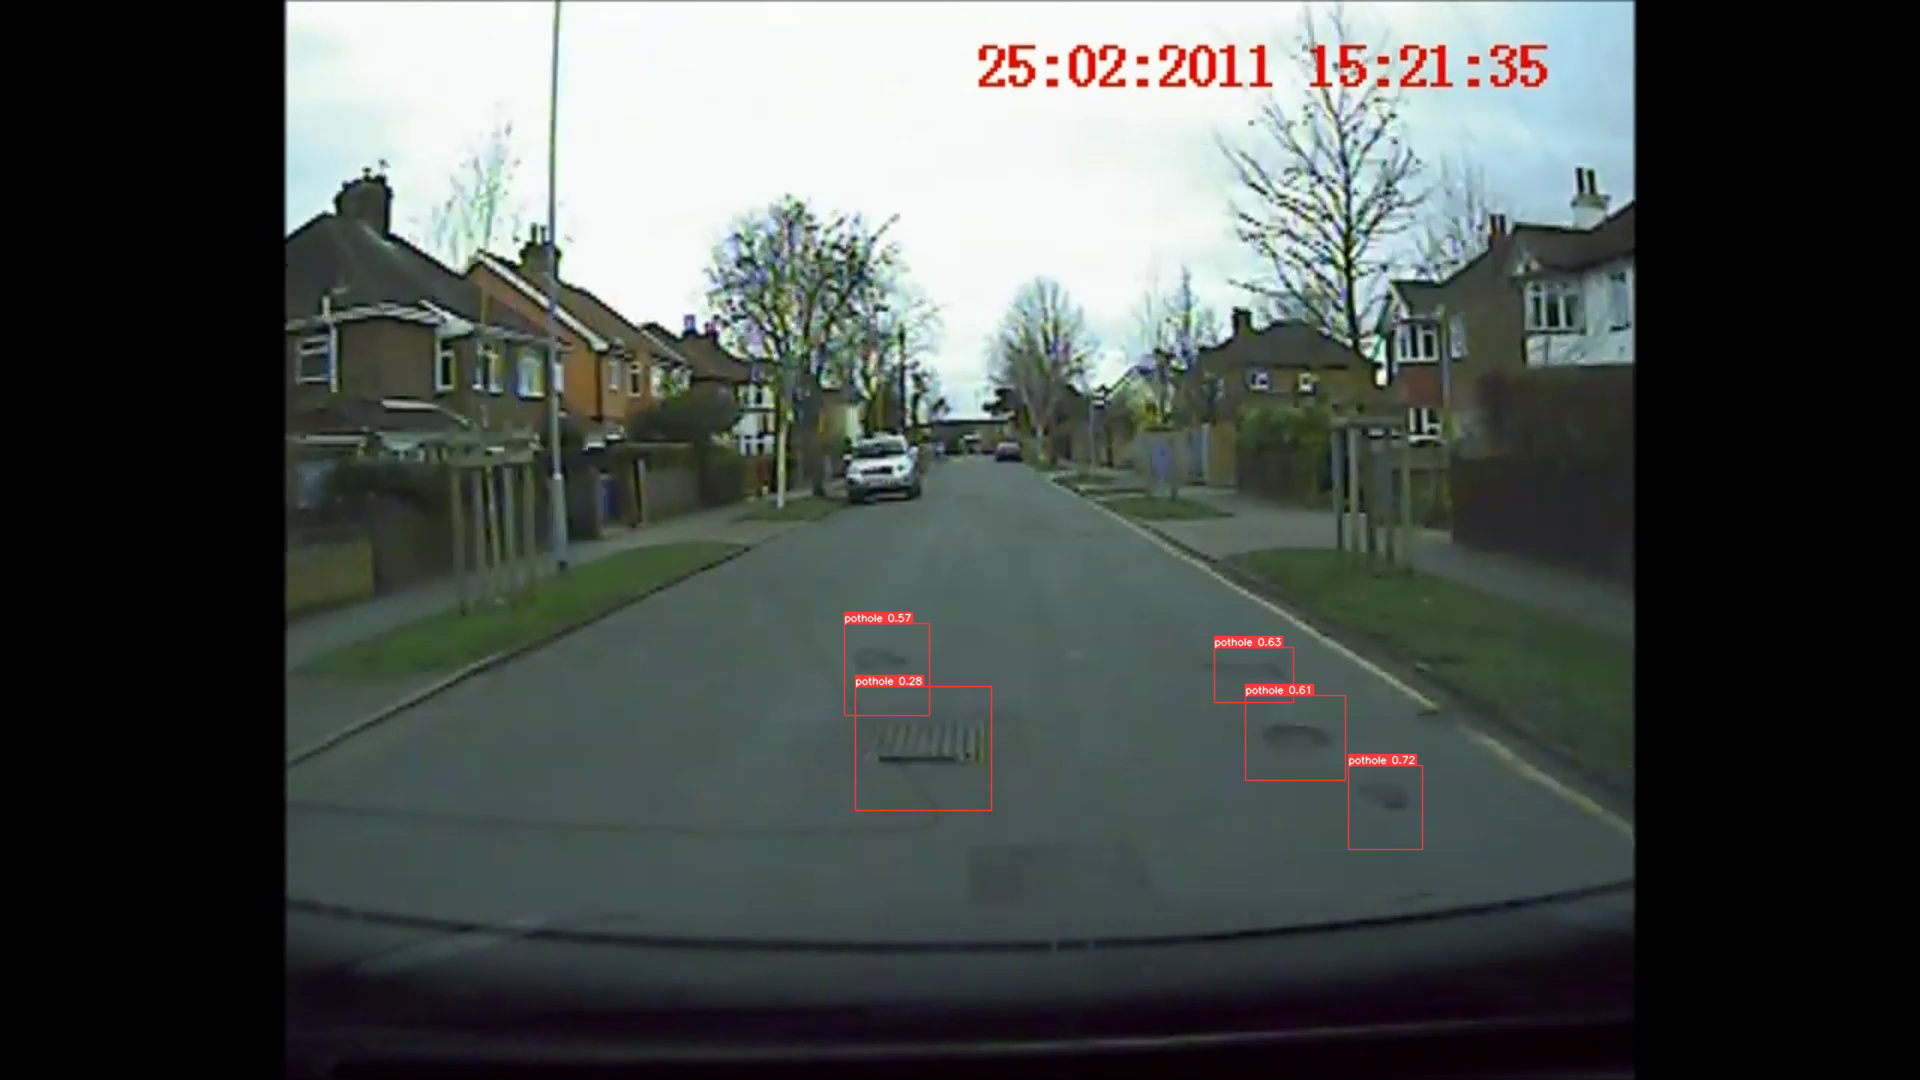

In [15]:
IMAGE_PATH = 'extracted 5 fps/28.jpg'

device = "CPU"
if device != "CPU":
    det_ov_model.reshape({0: [1, 3, 480, 480]})
quantized_det_model_optimized = core.compile_model(quantized_det_model, device)

input_image = np.array(Image.open(IMAGE_PATH))
detections = detect(input_image, det_compiled_model)[0]
image_with_boxes = draw_results(detections, input_image, label_map)

Image.fromarray(image_with_boxes)

# **BENCHMARKING QUANTIZED AND UNQUANTIZED MODEL**

### *ORIGINAL MODEL*

In [32]:
det_model_apth = './POTHOLE/TRAINING001/weights/best_openvino_model/best.xml'
device = 'CPU'

!benchmark_app -m $det_model_apth -d $device -api async -shape "[1,3,480,480]"

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2023.0.0-10926-b4452d56304-releases/2023/0
[ INFO ] 
[ INFO ] Device info:
[ INFO ] CPU
[ INFO ] Build ................................. 2023.0.0-10926-b4452d56304-releases/2023/0
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(CPU) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 25.00 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     images (node: images) : f32 / [...] / [?,3,?,?]
[ INFO ] Model outputs:
[ INFO ]     output0 (node: output0) : f32 / [...] / [?,5,?]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch size: 1
[ INFO ] Reshaping model:

### *QUANTIZED MODEL*

In [52]:
det_model_apth_quantized = './POTHOLE/TRAINING001/weights/quantized/serialized_quantized_model.xml'
device = 'CPU'

!benchmark_app -m $det_model_apth_quantized -d $device -api async -shape "[1,3,480,480]" -t 15

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2023.0.0-10926-b4452d56304-releases/2023/0
[ INFO ] 
[ INFO ] Device info:
[ INFO ] CPU
[ INFO ] Build ................................. 2023.0.0-10926-b4452d56304-releases/2023/0
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(CPU) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 57.78 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     images (node: images) : f32 / [...] / [1,3,?,?]
[ INFO ] Model outputs:
[ INFO ]     output0 (node: output0) : f32 / [...] / [1,5,21..]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch size: 1
[ INFO ] Reshaping mod

# **MODEL INTEGRATION**

In [16]:
# initiate preprocess
integrated_model = PrePostProcessor(quantized_det_model)

# define input format
integrated_model.input(0).tensor().set_shape([1,480,480,3]).set_element_type(Type.u8).set_layout(Layout('NHWC'))
pass

In [17]:
# describing preprocessing steps
integrated_model.input(0).preprocess().convert_element_type(Type.f32).convert_layout(Layout('NCHW')).scale([255., 255., 255.])
print(integrated_model)

Input "images":
    User's input tensor: [1,480,480,3], [N,H,W,C], u8
    Model's expected tensor: [1,3,480,480], [N,C,H,W], f32
    Pre-processing steps (3):
      convert type (f32): ([1,480,480,3], [N,H,W,C], u8) -> ([1,480,480,3], [N,H,W,C], f32)
      convert layout [N,C,H,W]: ([1,480,480,3], [N,H,W,C], f32) -> ([1,3,480,480], [N,C,H,W], f32)
      scale (255,255,255): ([1,3,480,480], [N,C,H,W], f32) -> ([1,3,480,480], [N,C,H,W], f32)



In [18]:
# saving model
model_with_preprocess_path = './POTHOLE/TRAINING001/weights/quantized//quantized_with_preprocess.xml'
quantized_model_with_preprocess = integrated_model.build()

In [ ]:
serialize(model=quantized_model_with_preprocess, 
          xml_path=model_with_preprocess_path)

### *INFERENCE TEST ON MODEL WITH PREPROCESSING*

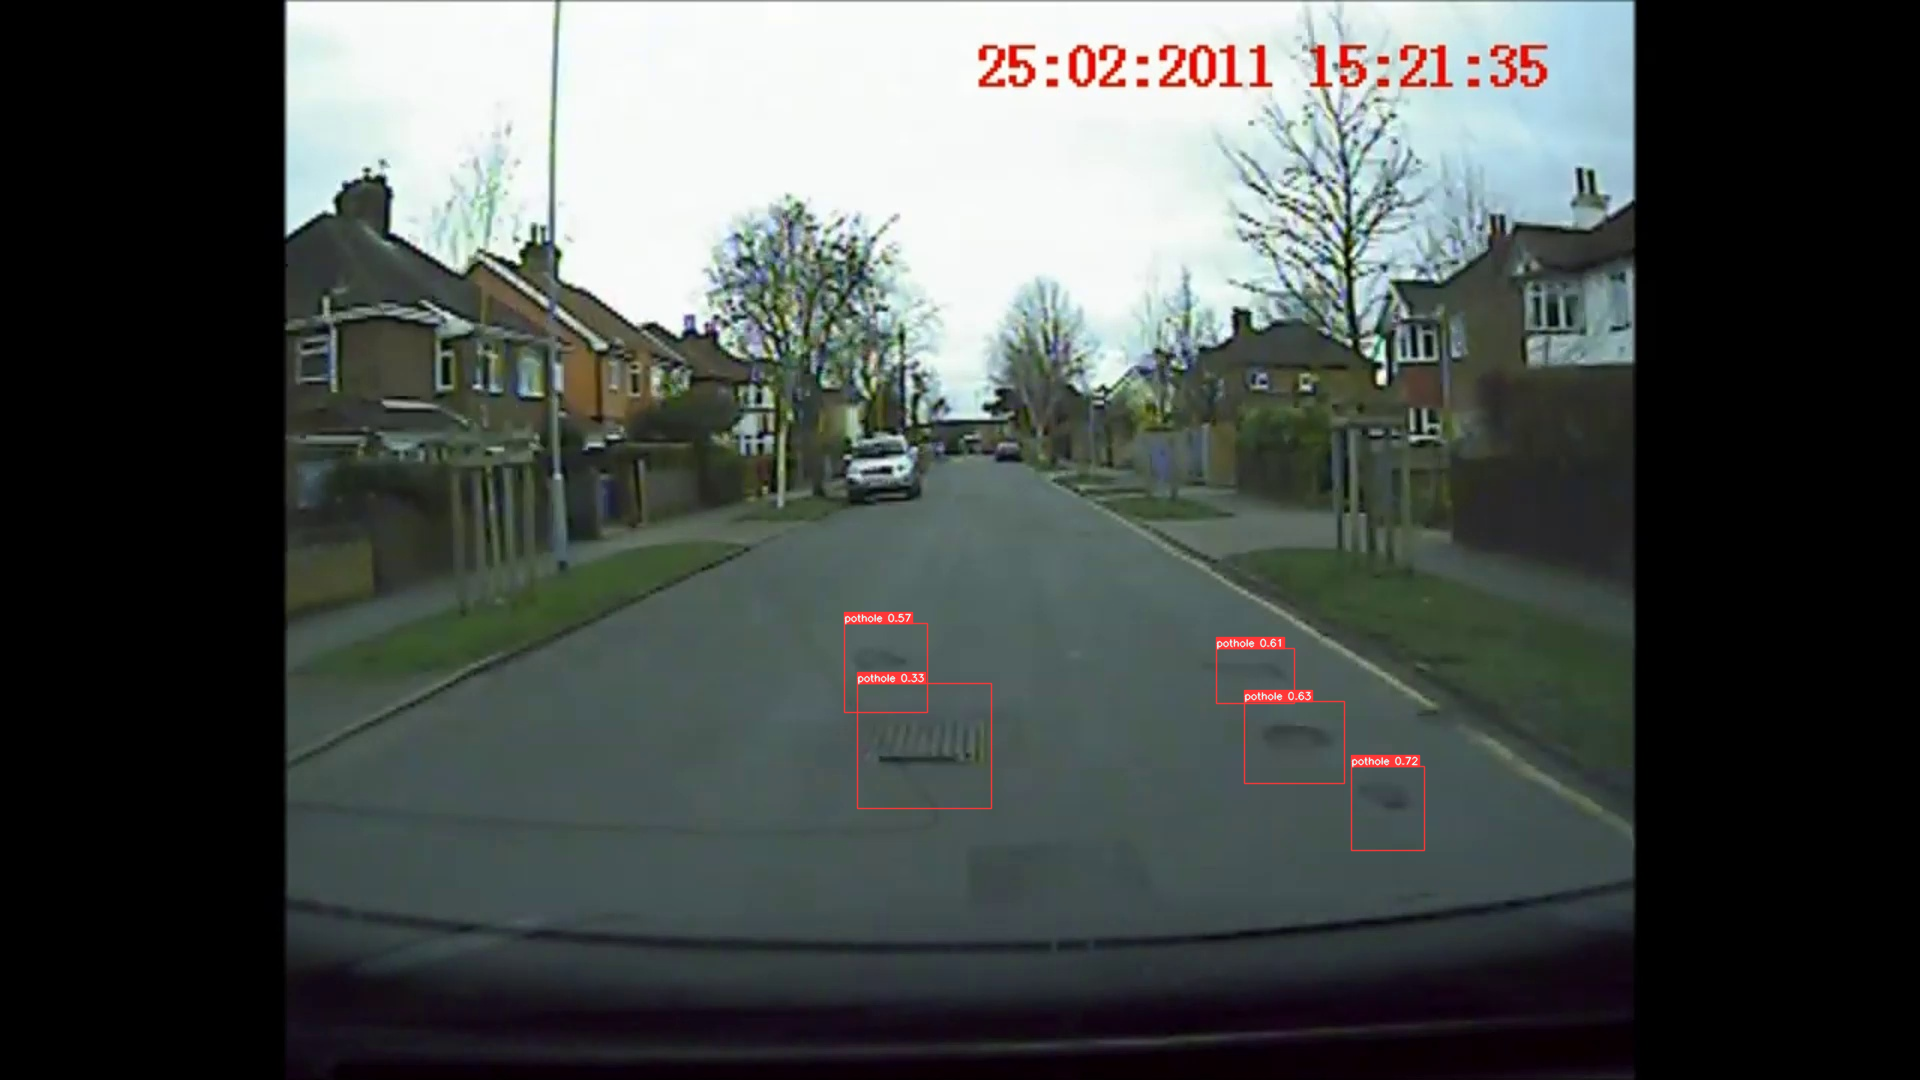

In [19]:
def detect_without_preprocess(image:np.ndarray, model:Model):
    """
    OpenVINO YOLOv8 model with integrated preprocessing inference function. Preprocess image, runs model inference and postprocess results using NMS.
    Parameters:
        image (np.ndarray): input image.
        model (Model): OpenVINO compiled model.
    Returns:
        detections (np.ndarray): detected boxes in format [x1, y1, x2, y2, score, label]
    """
    output_layer = model.output(0)
    img = letterbox(image)[0]
    input_tensor = np.expand_dims(img, 0)
    input_hw = img.shape[:2]
    result = model(input_tensor)[output_layer]
    detections = postprocess(result, input_hw, image)
    return detections

device = 'CPU'
compiled_model = core.compile_model(quantized_model_with_preprocess, device)
input_image = np.array(Image.open(IMAGE_PATH))
detections = detect_without_preprocess(input_image, compiled_model)[0]
image_with_boxes = draw_results(detections, input_image, label_map)

Image.fromarray(image_with_boxes)

# **RUNNING MODEL**

In [22]:
# Fetch the notebook utils script from the openvino_notebooks repo
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py',
    filename='notebook_utils.py'
)

('notebook_utils.py', <http.client.HTTPMessage at 0x19303ee9d20>)

### *RUNNING MODEL WITH UNINTEGRATED PREPROCESSING*

In [20]:
def run_object_detection(source=0, flip=False, use_popup=False, skip_first_frames=0, model=quantized_model_with_preprocess, device=device):
    player = None
    if device != "CPU":
        model.reshape({0: [1, 3, 480, 480]})
    compiled_model = core.compile_model(model, device)
    try:
        # Create a video player to play with target fps.
        player = VideoPlayer(
            source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames
        )
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(
                winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE
            )

        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )
            # Get the results.
            input_image = np.array(frame)
           
            start_time = time.time()
            # model expects RGB image, while video capturing in BGR
            detections = detect(input_image, compiled_model)[0]
            stop_time = time.time()
            
            image_with_boxes = draw_results(detections, input_image, label_map)
            frame = image_with_boxes
           
            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # Mean processing time [ms].
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(
                img=frame,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=1,
                lineType=cv2.LINE_AA,
            )
            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(winname=title, mat=frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(
                    ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100]
                )
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

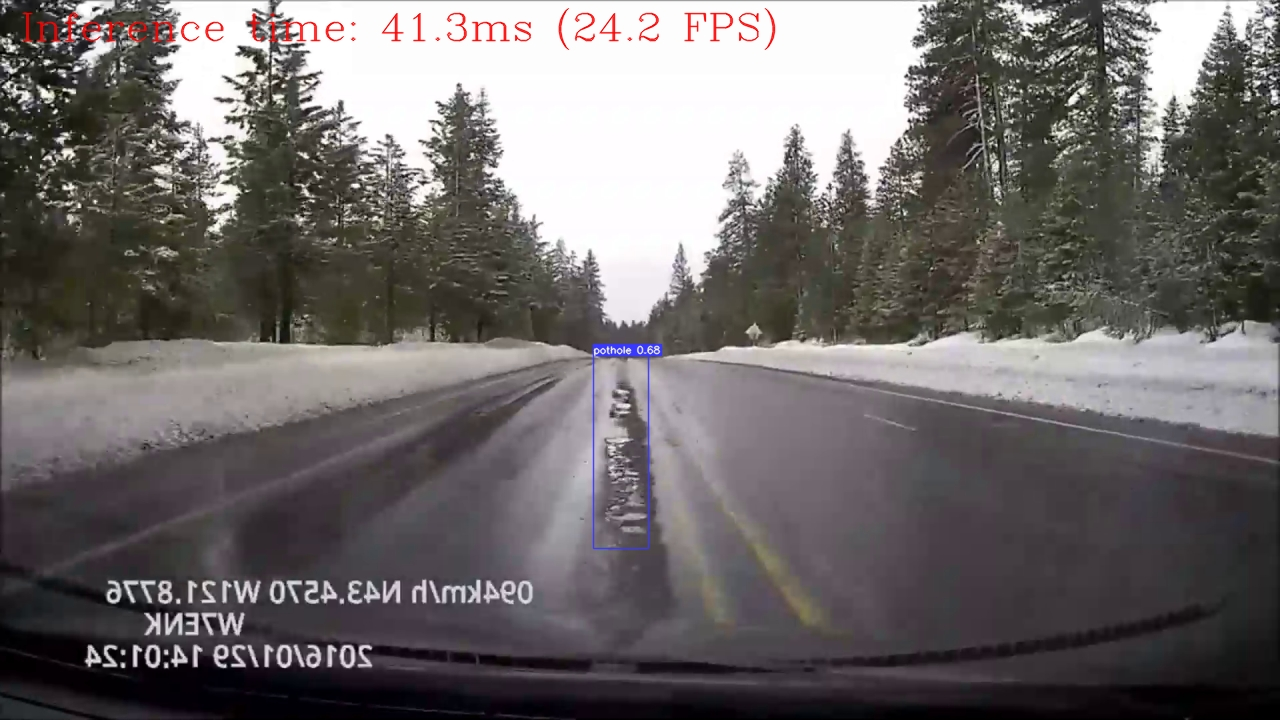

Interrupted


In [21]:
VIDEOSOURCE = "./test video.mp4"

run_object_detection(source=VIDEOSOURCE,
                     flip=True,
                     use_popup=False,
                     model=det_ov_model,
                     device='CPU')

### *RUNNING MODEL WITH INTEGRATED PROCESSING*

In [22]:
def run_object_detection_without_preprocess(source=0, flip=False, use_popup=False, skip_first_frames=0, model=quantized_model_with_preprocess, device=device):
    player = None
    if device != "CPU":
        model.reshape({0: [1, 3, 480, 480]})
    compiled_model = core.compile_model(model, device)
    try:
        # Create a video player to play with target fps.
        player = VideoPlayer(
            source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames
        )
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(
                winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE
            )

        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )
            # Get the results.
            input_image = np.array(frame)
           
            start_time = time.time()
            # model expects RGB image, while video capturing in BGR
            detections = detect_without_preprocess(input_image, compiled_model)[0]
            stop_time = time.time()
            
            image_with_boxes = draw_results(detections, input_image, label_map)
            frame = image_with_boxes
           
            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # Mean processing time [ms].
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(
                img=frame,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=1,
                lineType=cv2.LINE_AA,
            )
            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(winname=title, mat=frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(
                    ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100]
                )
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

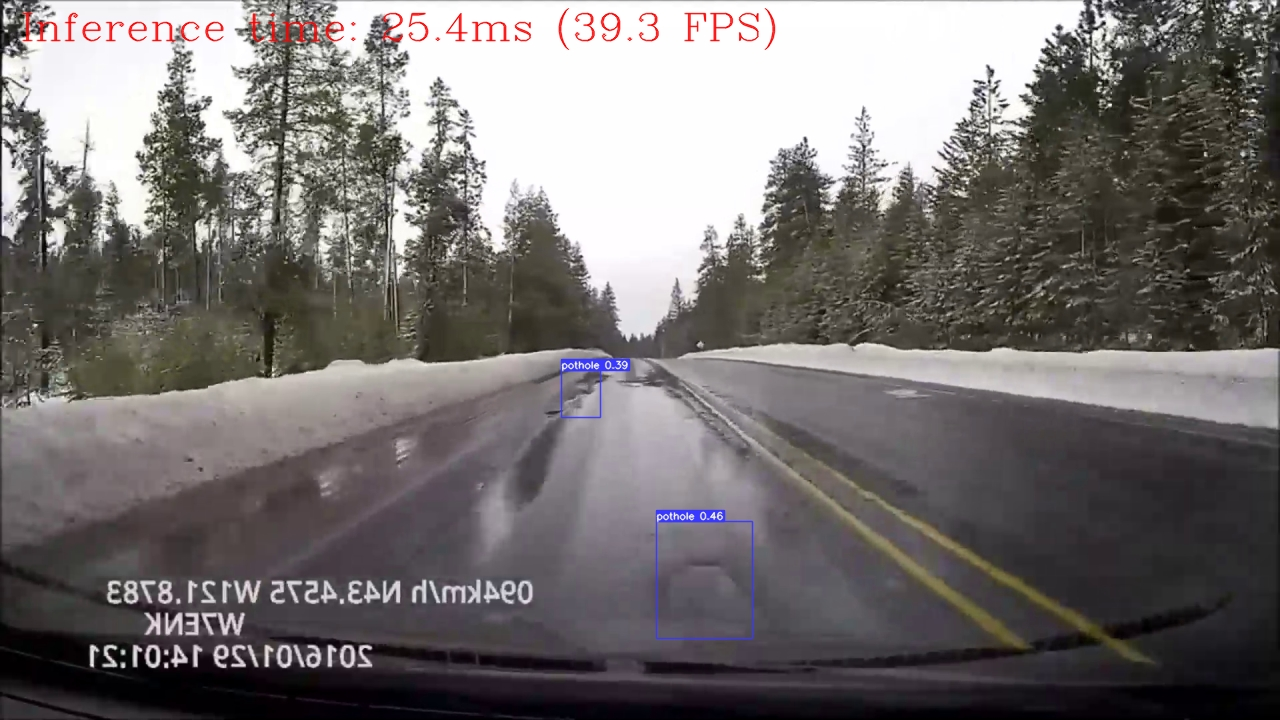

Interrupted


In [24]:
VIDEOSOURCE = "./test video.mp4"

run_object_detection_without_preprocess(source=VIDEOSOURCE,
                                        flip=True,
                                        use_popup=False,
                                        model=quantized_model_with_preprocess,
                                        device='CPU')